# Figure out the NA values in Neighbourhoods

In [1]:
import sys
sys.path.append("../../code")
import preprocess_change_col_type
import altair_data_transformer
import find_na_neighborhood_name

import altair as alt
import pre_commit as pc
import pandas as pd

from scipy.spatial import cKDTree

data_dir = 'altairdata'
altair_data_transformer.setup_altair_for_large_data(data_dir)

In [2]:
import importlib

importlib.reload(find_na_neighborhood_name)

<module 'find_na_neighborhood_name' from 'C:\\Users\\ljung\\Desktop\\git\\dsci320\\project-team_kbn\\analysis\\Picnic\\../../code\\find_na_neighborhood_name.py'>

## Overview

During the Exploratory Data Analysis phase in Milestone 2, it was observed that a significant number (3928 in specific) of samples had missing values (`NA`) in the `NEIGHBOURHOOD_NAME` column. Upon visualizing these missing entries on a map, it became evident that:
1. Many of the points were concentrated in **Stanley Park** and areas around **UBC**, particularly in the **West Point Grey** neighborhood, including **Spanish Bank**.
2. A smaller subset of points appeared to belong to existing neighborhoods but were likely missed during data collection.

To address this issue, a multi-step approach was implemented to impute the missing `NEIGHBOURHOOD_NAME` values based on geographical coordinates. Below is a detailed explanation of the methodology used.


In [3]:
processed_df = pd.read_csv("../../data/processed/public_trees_cleaned.csv")

# covert column to respective column type
processed_df = preprocess_change_col_type.convert_column_types(processed_df)

In [4]:
# number of samples that has NA values in NEIGHBOURHOOD_NAME
processed_df['NEIGHBOURHOOD_NAME'].isna().sum()

np.int64(3928)

## Methodology

## 1: Assign Neighborhoods Using Overpass API

- Used the Overpass API , an open-source tool developed by Geofabrik GmbH, to retrieve geographical boundaries for Stanley Park and West Point Grey/Spanish Bank (Geofabrik GmbH, n.d.).
- Assigned NEIGHBOURHOOD_NAME to points falling within these boundaries.

### Results
- 3,731 points were successfully labeled as Stanley Park.
- 191 points were successfully labeled as West Point Grey (located in the Spanish Bank area, which is considered part of West Point Grey).

In [5]:
# stanley park

way_id = 37063023
coordinates = find_na_neighborhood_name.get_boundary_by_way_id(way_id)
park_polygon = find_na_neighborhood_name.create_park_polygon_from_coordinates(coordinates)
new = find_na_neighborhood_name.assign_neighborhood_to_points(processed_df, park_polygon, "STANLEY PARK")

# Devonian Harbour Park (extension of stanley park)
way_id = 37056115
coordinates = find_na_neighborhood_name.get_boundary_by_way_id(way_id)
park_polygon = find_na_neighborhood_name.create_park_polygon_from_coordinates(coordinates)
new = find_na_neighborhood_name.assign_neighborhood_to_points(processed_df, park_polygon, "STANLEY PARK")


# spanish banks - part of west point gray

way_id = 341703892
coordinates = find_na_neighborhood_name.get_boundary_by_way_id(way_id)
park_polygon = find_na_neighborhood_name.create_park_polygon_from_coordinates(coordinates)
new = find_na_neighborhood_name.assign_neighborhood_to_points(processed_df, park_polygon, "WEST POINT GREY")

# spanish banks as well - extended to the beach
way_id = 56688927
coordinates = find_na_neighborhood_name.get_boundary_by_way_id(way_id)
park_polygon = find_na_neighborhood_name.create_park_polygon_from_coordinates(coordinates)
new = find_na_neighborhood_name.assign_neighborhood_to_points(processed_df, park_polygon, "WEST POINT GREY")

# 3731 points NA labelled as stanley park
# 191 points NA labelled as spanish banks
new['NEIGHBOURHOOD_NAME'].isna().sum()

np.int64(6)

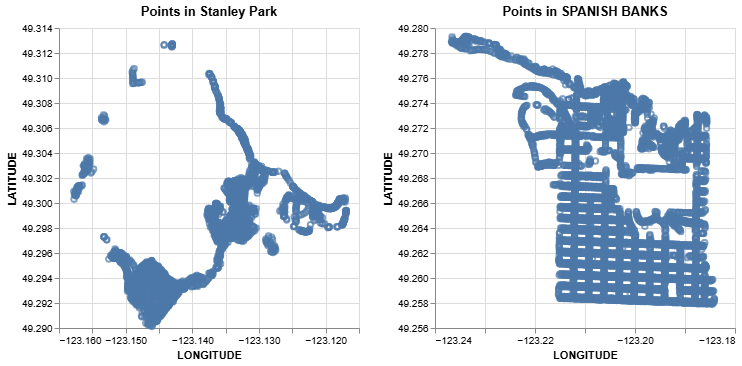

In [6]:
# confirm these 2 looks like stanley park + spanish banks (part of west point grey)
# it does from the bare eyes

# Filter the data to include only points from Stanley Park
stanley_park_df = new[new['NEIGHBOURHOOD_NAME'] == 'STANLEY PARK']

chart_stanley_park = alt.Chart(stanley_park_df).mark_point().encode(
    x=alt.X('LONGITUDE', scale=alt.Scale(zero=False)),
    y=alt.Y('LATITUDE', scale=alt.Scale(zero=False)),  
).properties(
    title='Points in Stanley Park'
)

# Filter the data to include only points from spanish banks
stanley_park_df = new[new['NEIGHBOURHOOD_NAME'] == 'WEST POINT GREY']

chart_spanish_banks = alt.Chart(stanley_park_df).mark_point().encode(
    x=alt.X('LONGITUDE', scale=alt.Scale(zero=False)),
    y=alt.Y('LATITUDE', scale=alt.Scale(zero=False)),  
).properties(
    title='Points in SPANISH BANKS'
)

side_by_side_chart = chart_stanley_park | chart_spanish_banks
side_by_side_chart

## 2: Classify Remaining Points Using KNN

After applying Step 1, only 6 points remain unassigned to a neighborhood. Based on the EDA from Milestone 2, it is evident that these points should belong to an existing neighborhood.

- To classify these remaining points, the K-Nearest Neighbors (KNN) algorithm was applied:
    - Used latitude and longitude as features.
    - Trained the model using points with known neighborhoods.
    - Assigned each unassigned point to the most frequent neighborhood among its k=10 nearest neighbors .

In [7]:
updated_df = find_na_neighborhood_name.assign_neighborhood_using_knn(new, k=10)

In [8]:
updated_df['NEIGHBOURHOOD_NAME'].isna().sum()

np.int64(0)

In [9]:
# check for 1 row that was NA and now has an assigned value. Check the long + lat on google, and looks about right.
updated_df[updated_df["TREE_ID"] == 141178]

,TREE_ID,CIVIC_NUMBER,STD_STREET,GENUS_NAME,SPECIES_NAME,CULTIVAR_NAME,COMMON_NAME,ON_STREET_BLOCK,ON_STREET,NEIGHBOURHOOD_NAME,...,DIAMETER,DATE_PLANTED,Geom,geo_point_2d,LATITUDE,LONGITUDE,NOMENCLATURE,ON_ADDRESS,FAMILY_NAME,HAS_POLLEN
11232,141178,3680,E 4TH AV,NYSSA,SYLVATICA,SYLVATICA,BLACK TUPELO,2000,BOUNDARY ROAD,HASTINGS-SUNRISE,...,9.5,NaT,"{""coordinates"": [-123.02355700012208, 49.26630...","49.266305999464315, -123.02355700012208",49.266306,-123.023557,NYSSA SYLVATICA,2000 BOUNDARY ROAD NA (MED),CORNACEAE,False


In [10]:
# Write the updated DataFrame back to the same CSV file
updated_df.to_csv("../../data/processed/public_trees_cleaned_filled_neighbhour.csv", index=False)

# Conclusion
Yay. Now we are done. This approach combined geographical boundaries and machine learning to effectively impute missing NEIGHBOURHOOD_NAME values, improving dataset completeness and reliability.

# Reference
- Geofabrik GmbH. (n.d.). Overpass API . Retrieved from https://wiki.openstreetmap.org/wiki/Overpass_API
- OpenStreetMap contributors. (n.d.). OpenStreetMap . Retrieved from https://www.openstreetmap.org